In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/project/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/project/data/Chickenpox/chickenpox68.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox99.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox74.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox103.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox75.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox86.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox13.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox45.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox60.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox72.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox57.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox104.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox9.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox42.png
/content/drive/MyDrive/project/data/Chickenpox/chickenpox80.png
/content/drive/MyDrive/project/data/Chi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Common
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output as cls

# Data
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2

#Directory Manipulation
import os
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
# Define the root directory
root_dir = '/content/drive/MyDrive/project/data'
# Get the class names
class_names = os.listdir(root_dir)


In [ ]:

# Create directories for the training, validation, and testing sets
train_dir = '/content/drive/MyDrive/project/folders/training'
val_dir = '/content/drive/MyDrive/project/folders/validation'
test_dir = '/content/drive/MyDrive/project/folders/testing'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the filenames in each class directory into training, validation, and testing sets
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    filenames = os.listdir(class_dir)
    train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.25, random_state=42)

    # Create directories for the class in the training, validation, and testing sets
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Copy the images to the class directories in the training, validation, and testing sets
    for filename in train_filenames:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(train_class_dir, filename)
        shutil.copyfile(src_path, dst_path)

    for filename in val_filenames:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(val_class_dir, filename)
        shutil.copyfile(src_path, dst_path)

    for filename in test_filenames:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(test_class_dir, filename)
        shutil.copyfile(src_path, dst_path)


In [ ]:
root_path = '/content/drive/MyDrive/project/data'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path +'/'+ name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 4 
Class Names : ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']


In [ ]:
# Visualize Whole
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [ ]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

# Load Data
train_ds = train_gen.flow_from_directory(train_dir, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
valid_ds = valid_gen.flow_from_directory(val_dir, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
test_ds = test_gen.flow_from_directory(test_dir, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)

Found 1458 images belonging to 4 classes.
Found 489 images belonging to 4 classes.
Found 488 images belonging to 4 classes.


In [ ]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()

        plt.title(title)
        plt.axis('off')

        i+=1
        if i>=(n_images+1):
            break

    plt.tight_layout()
    plt.show()

In [ ]:
def load_image(path):
    '''This function will load the image present at the given location'''
    image = tf.cast(tf.image.resize(img_to_array(load_img(path))/255., (256,256)), tf.float32)
    return image
def show_image(image, title=None):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

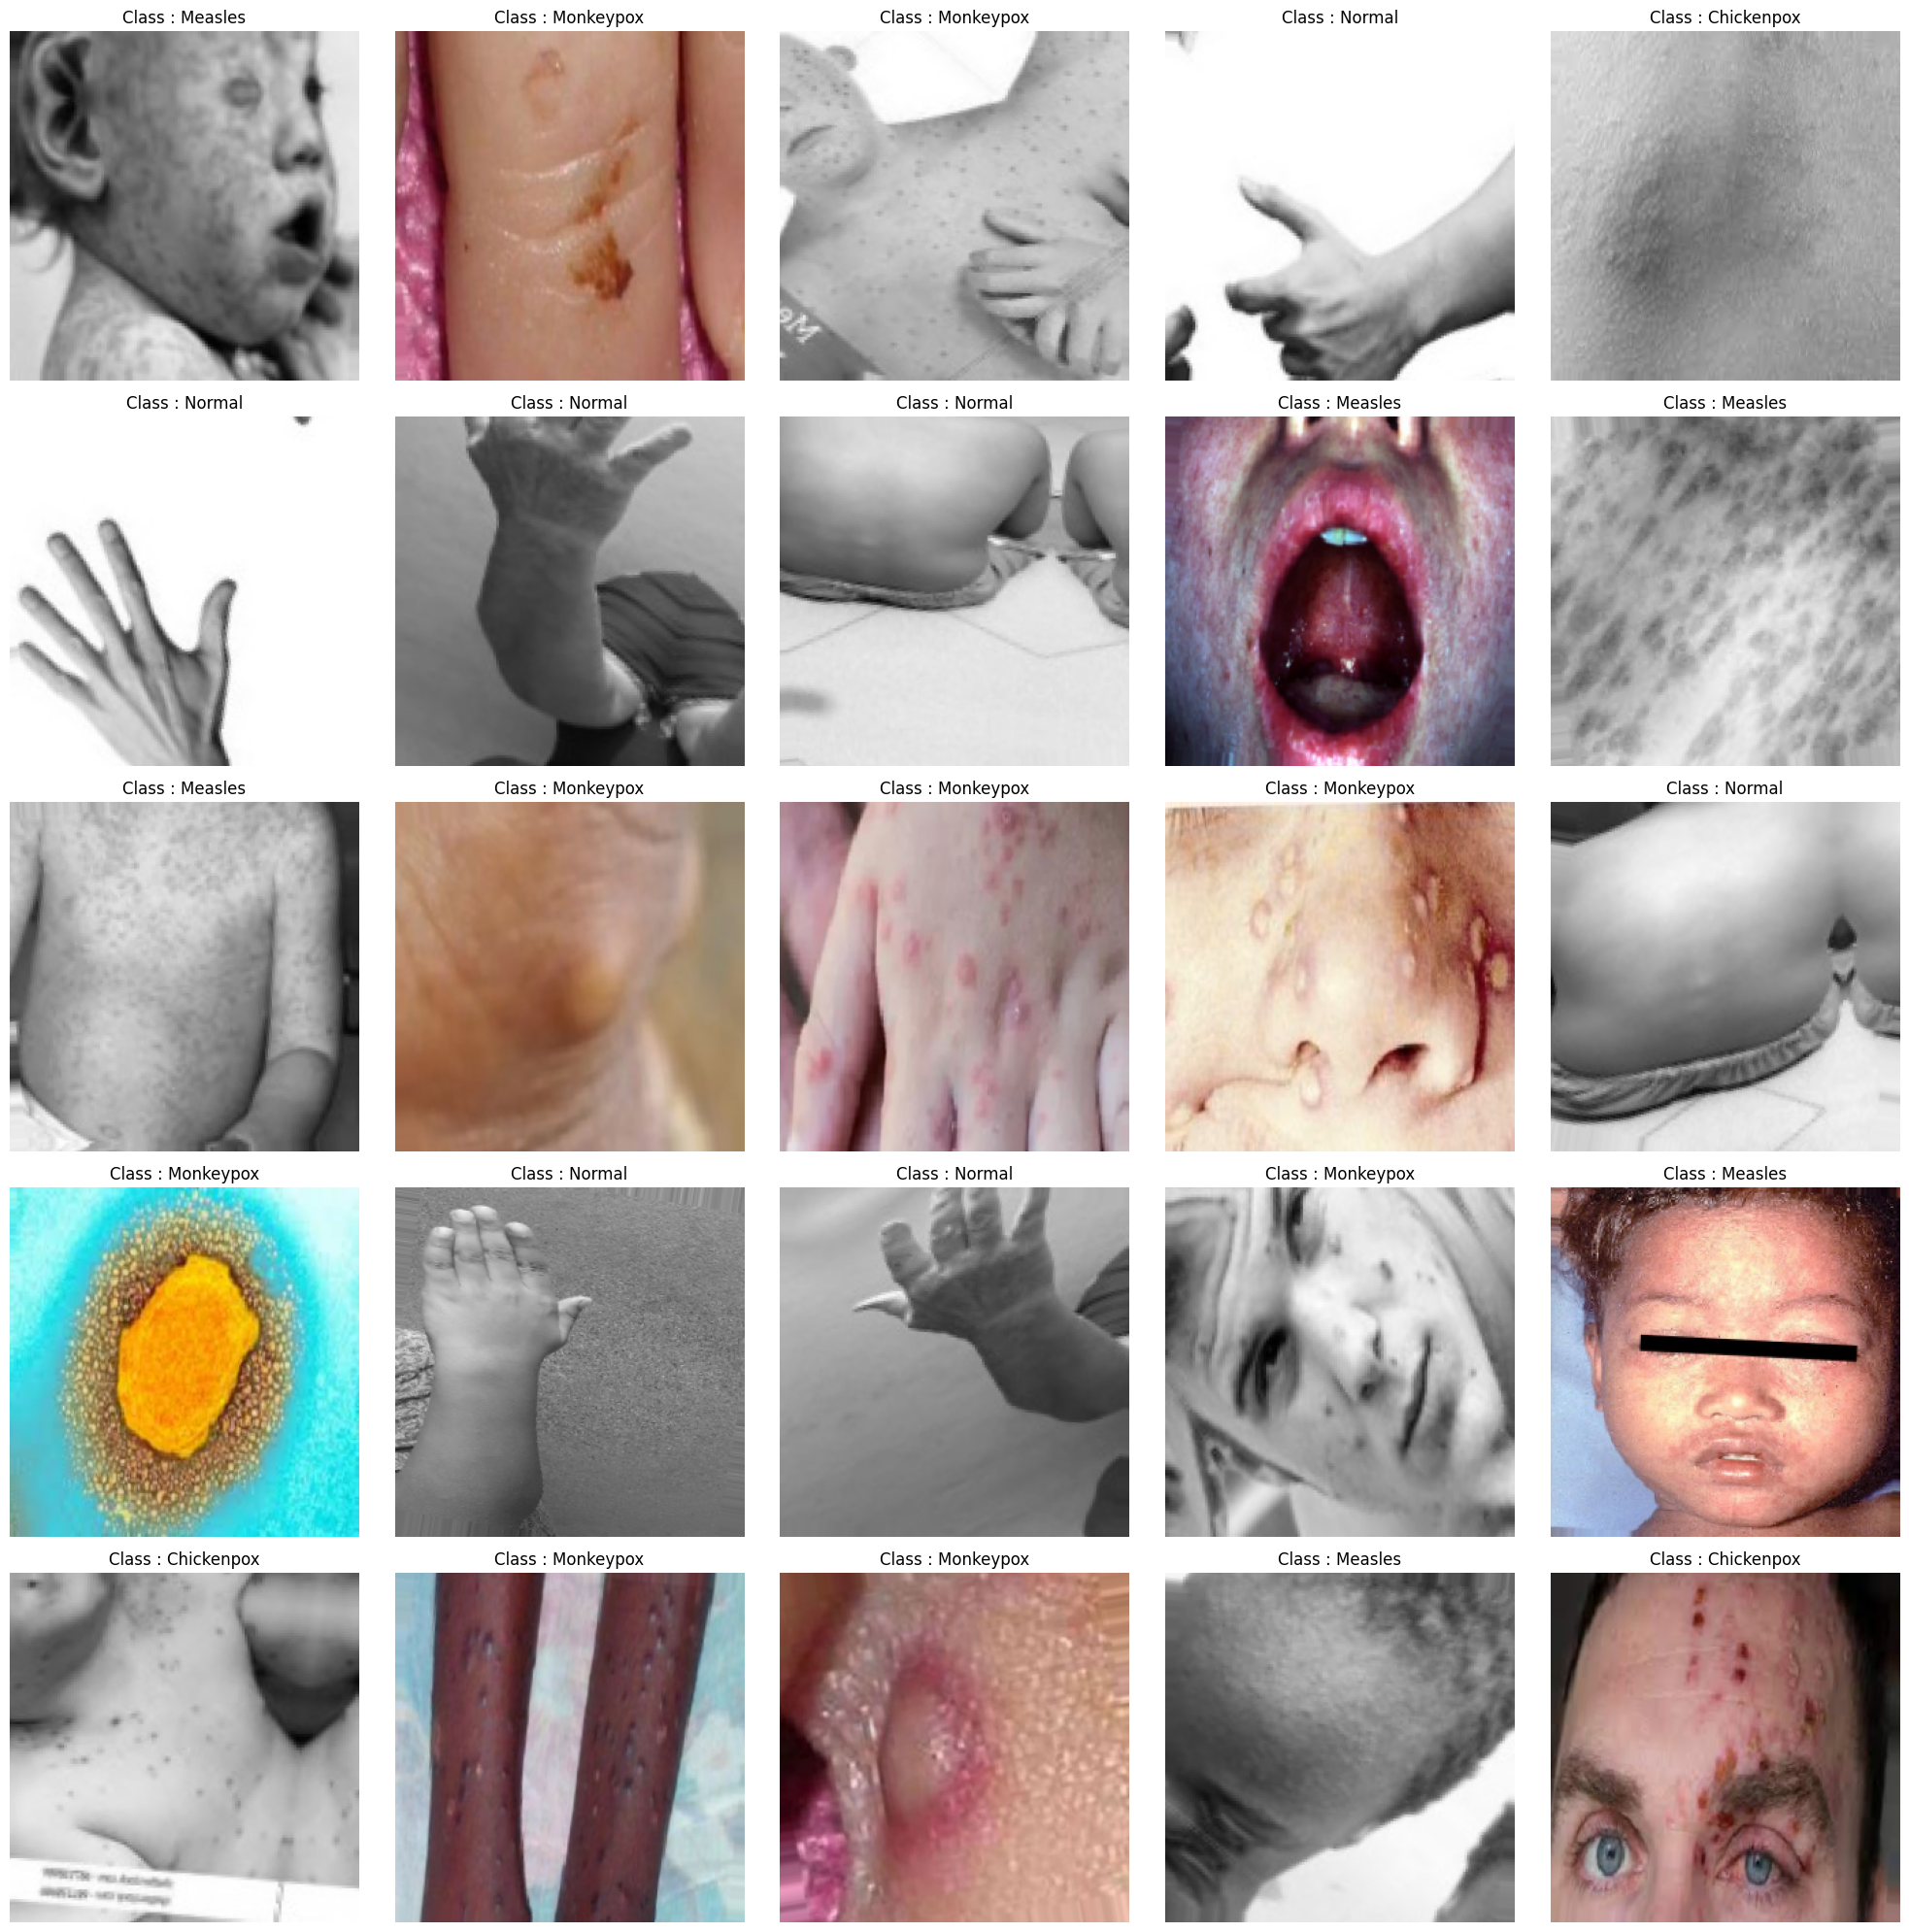

In [ ]:
#Visulaize Training Images
show_images(data=train_ds)

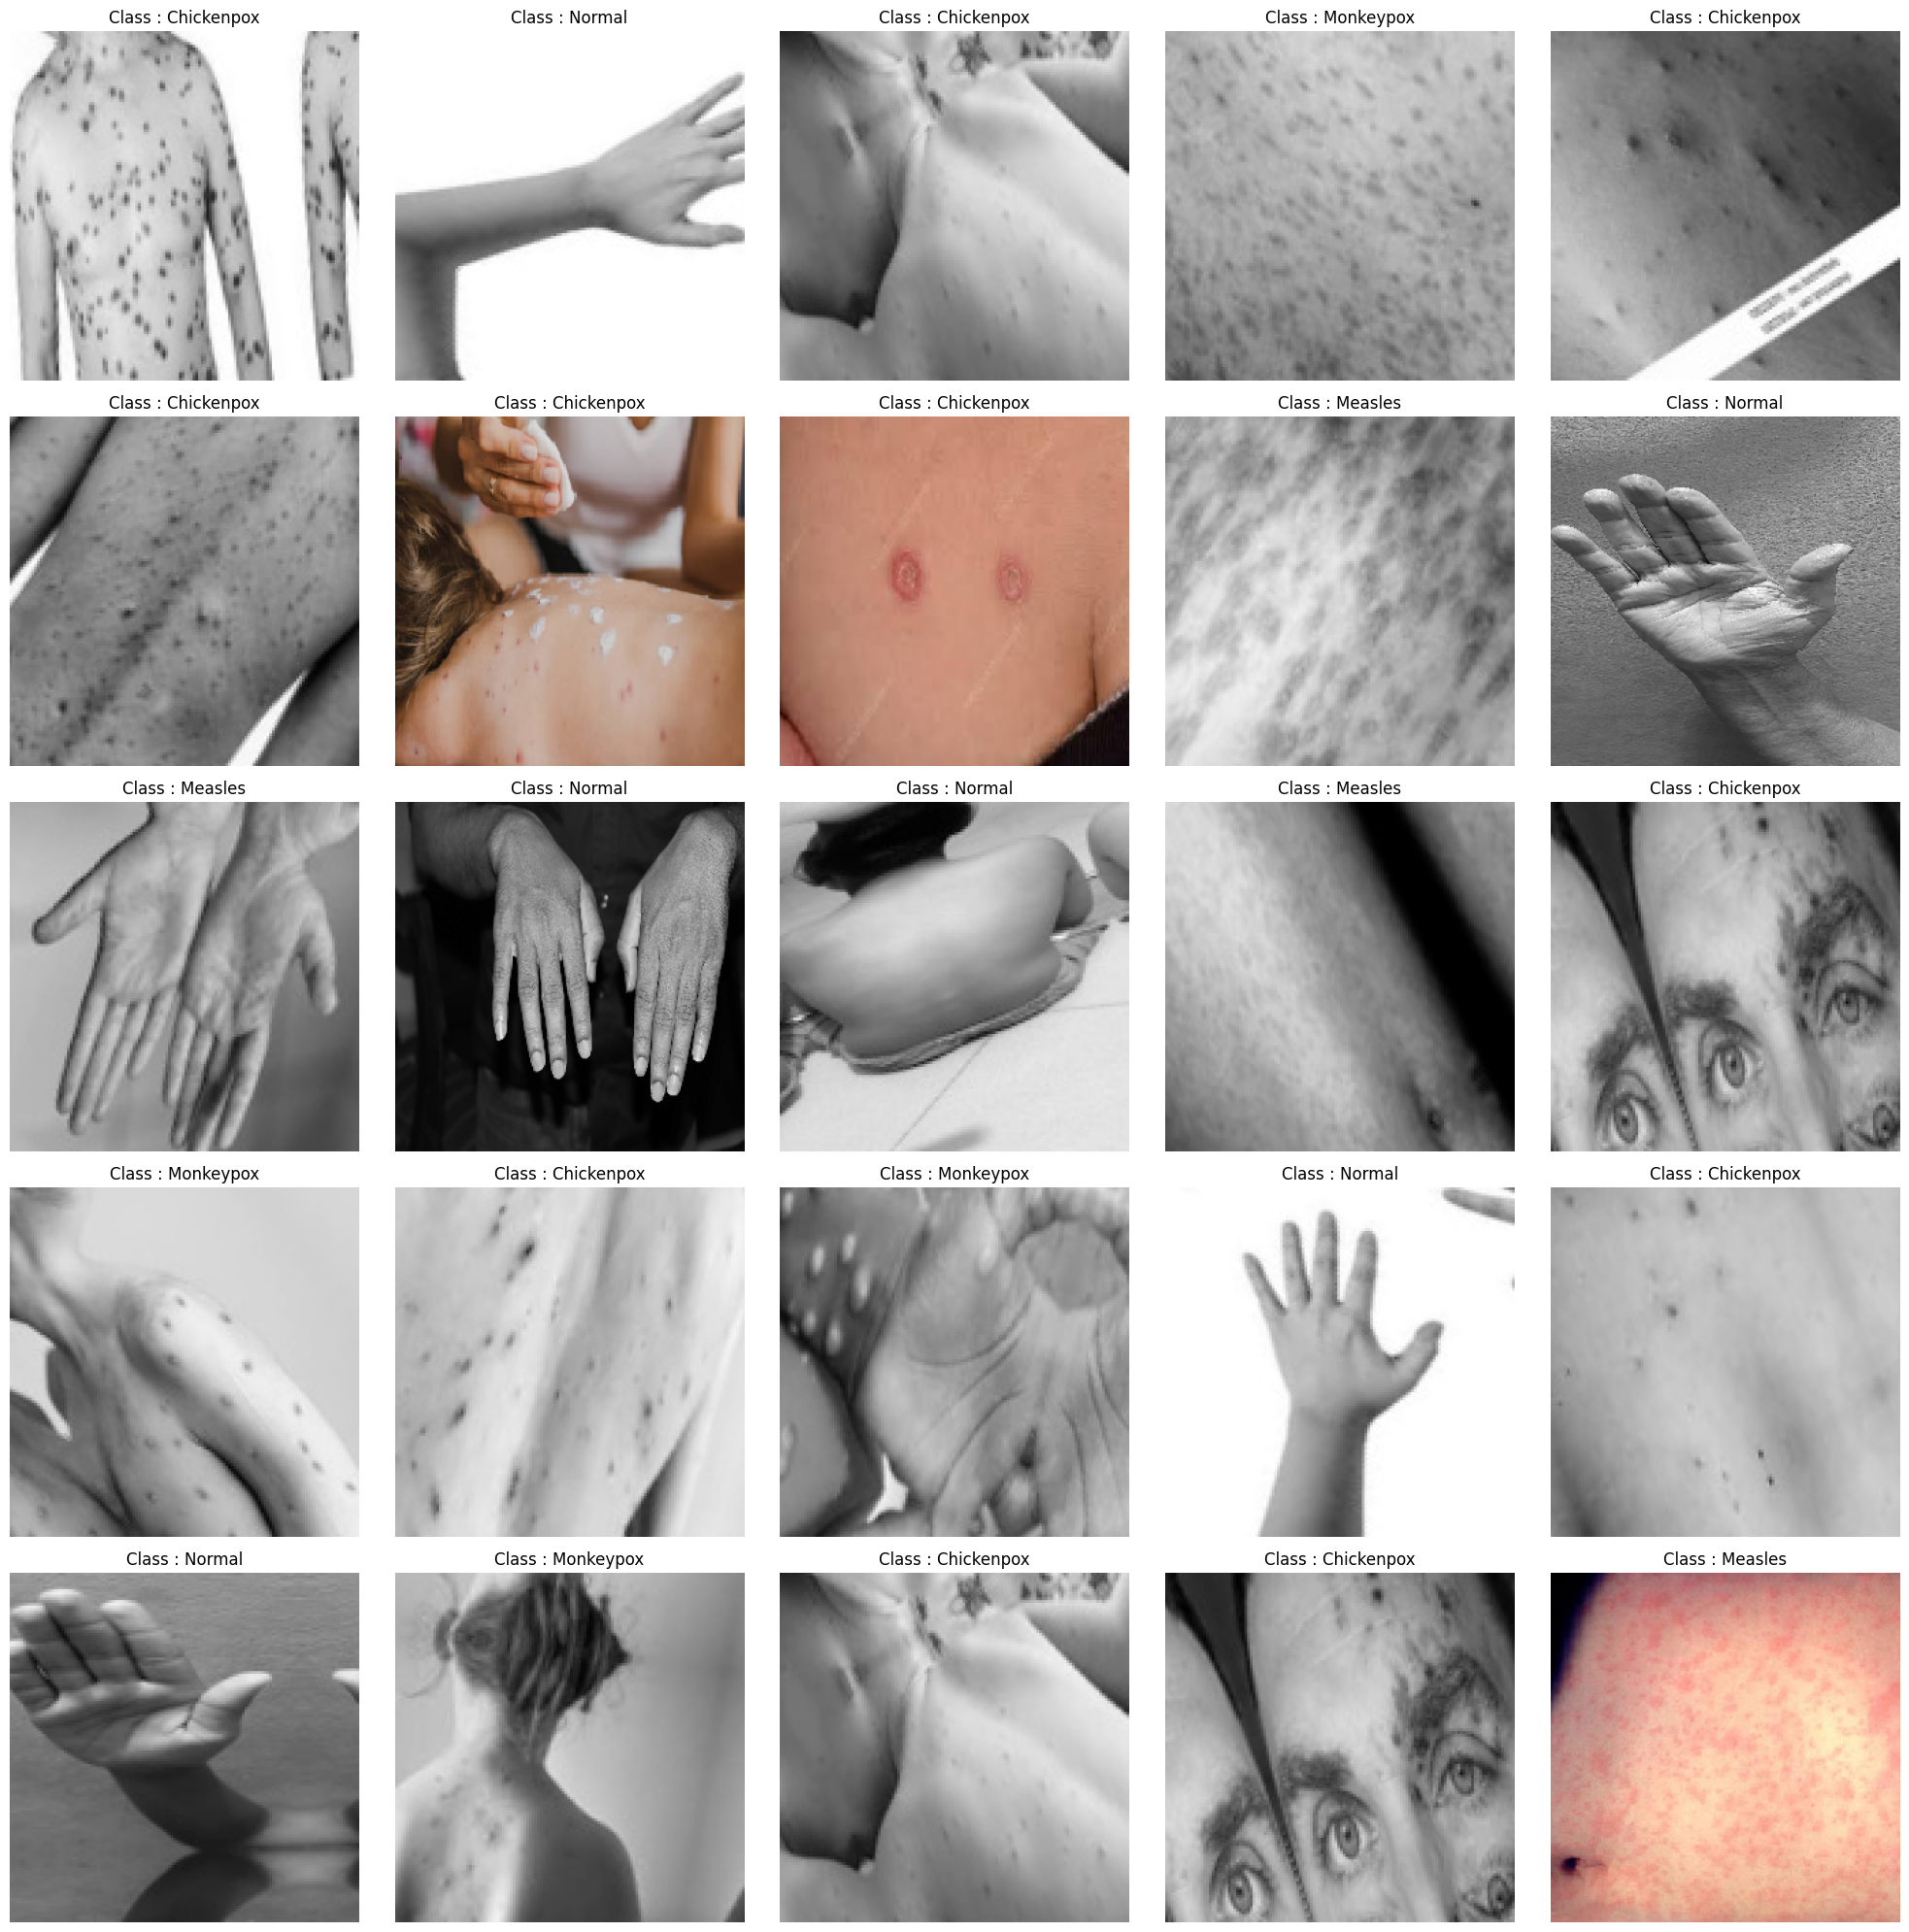

In [ ]:
#Visualize Test Images
show_images(data=valid_ds)

In [ ]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
model = Sequential([
    bit_module,
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name='bit-custom')

In [ ]:
BATCH_SIZE = 32
lr = 1e-3 * BATCH_SIZE/512
print(f"Learning rate : {lr}")

Learning rate : 6.25e-05


In [ ]:
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        lr,
        lr * 0.1,
        lr * 0.01,
        lr * 0.001,
    ],
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [ ]:
cbs = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint('bit-custom.h5', save_best_only=True)]

In [ ]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=4, callbacks=cbs)

Epoch 1/4
46/46 [==============================] - ETA: 0s - loss: 0.9147 - accuracy: 0.6255

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



46/46 [==============================] - 49s 790ms/step - loss: 0.9147 - accuracy: 0.6255 - val_loss: 0.6361 - val_accuracy: 0.7464
Epoch 2/4
46/46 [==============================] - 35s 766ms/step - loss: 0.5706 - accuracy: 0.7634 - val_loss: 0.5528 - val_accuracy: 0.7771
Epoch 3/4
46/46 [==============================] - 37s 805ms/step - loss: 0.4944 - accuracy: 0.7997 - val_loss: 0.5186 - val_accuracy: 0.7628
Epoch 4/4
46/46 [==============================] - 34s 740ms/step - loss: 0.4526 - accuracy: 0.8203 - val_loss: 0.4895 - val_accuracy: 0.7873


In [ ]:
#Evaluating the model
model.evaluate(test_ds)

16/16 [==============================] - 5s 297ms/step - loss: 0.4540 - accuracy: 0.8217


[0.4539790451526642, 0.8217213153839111]

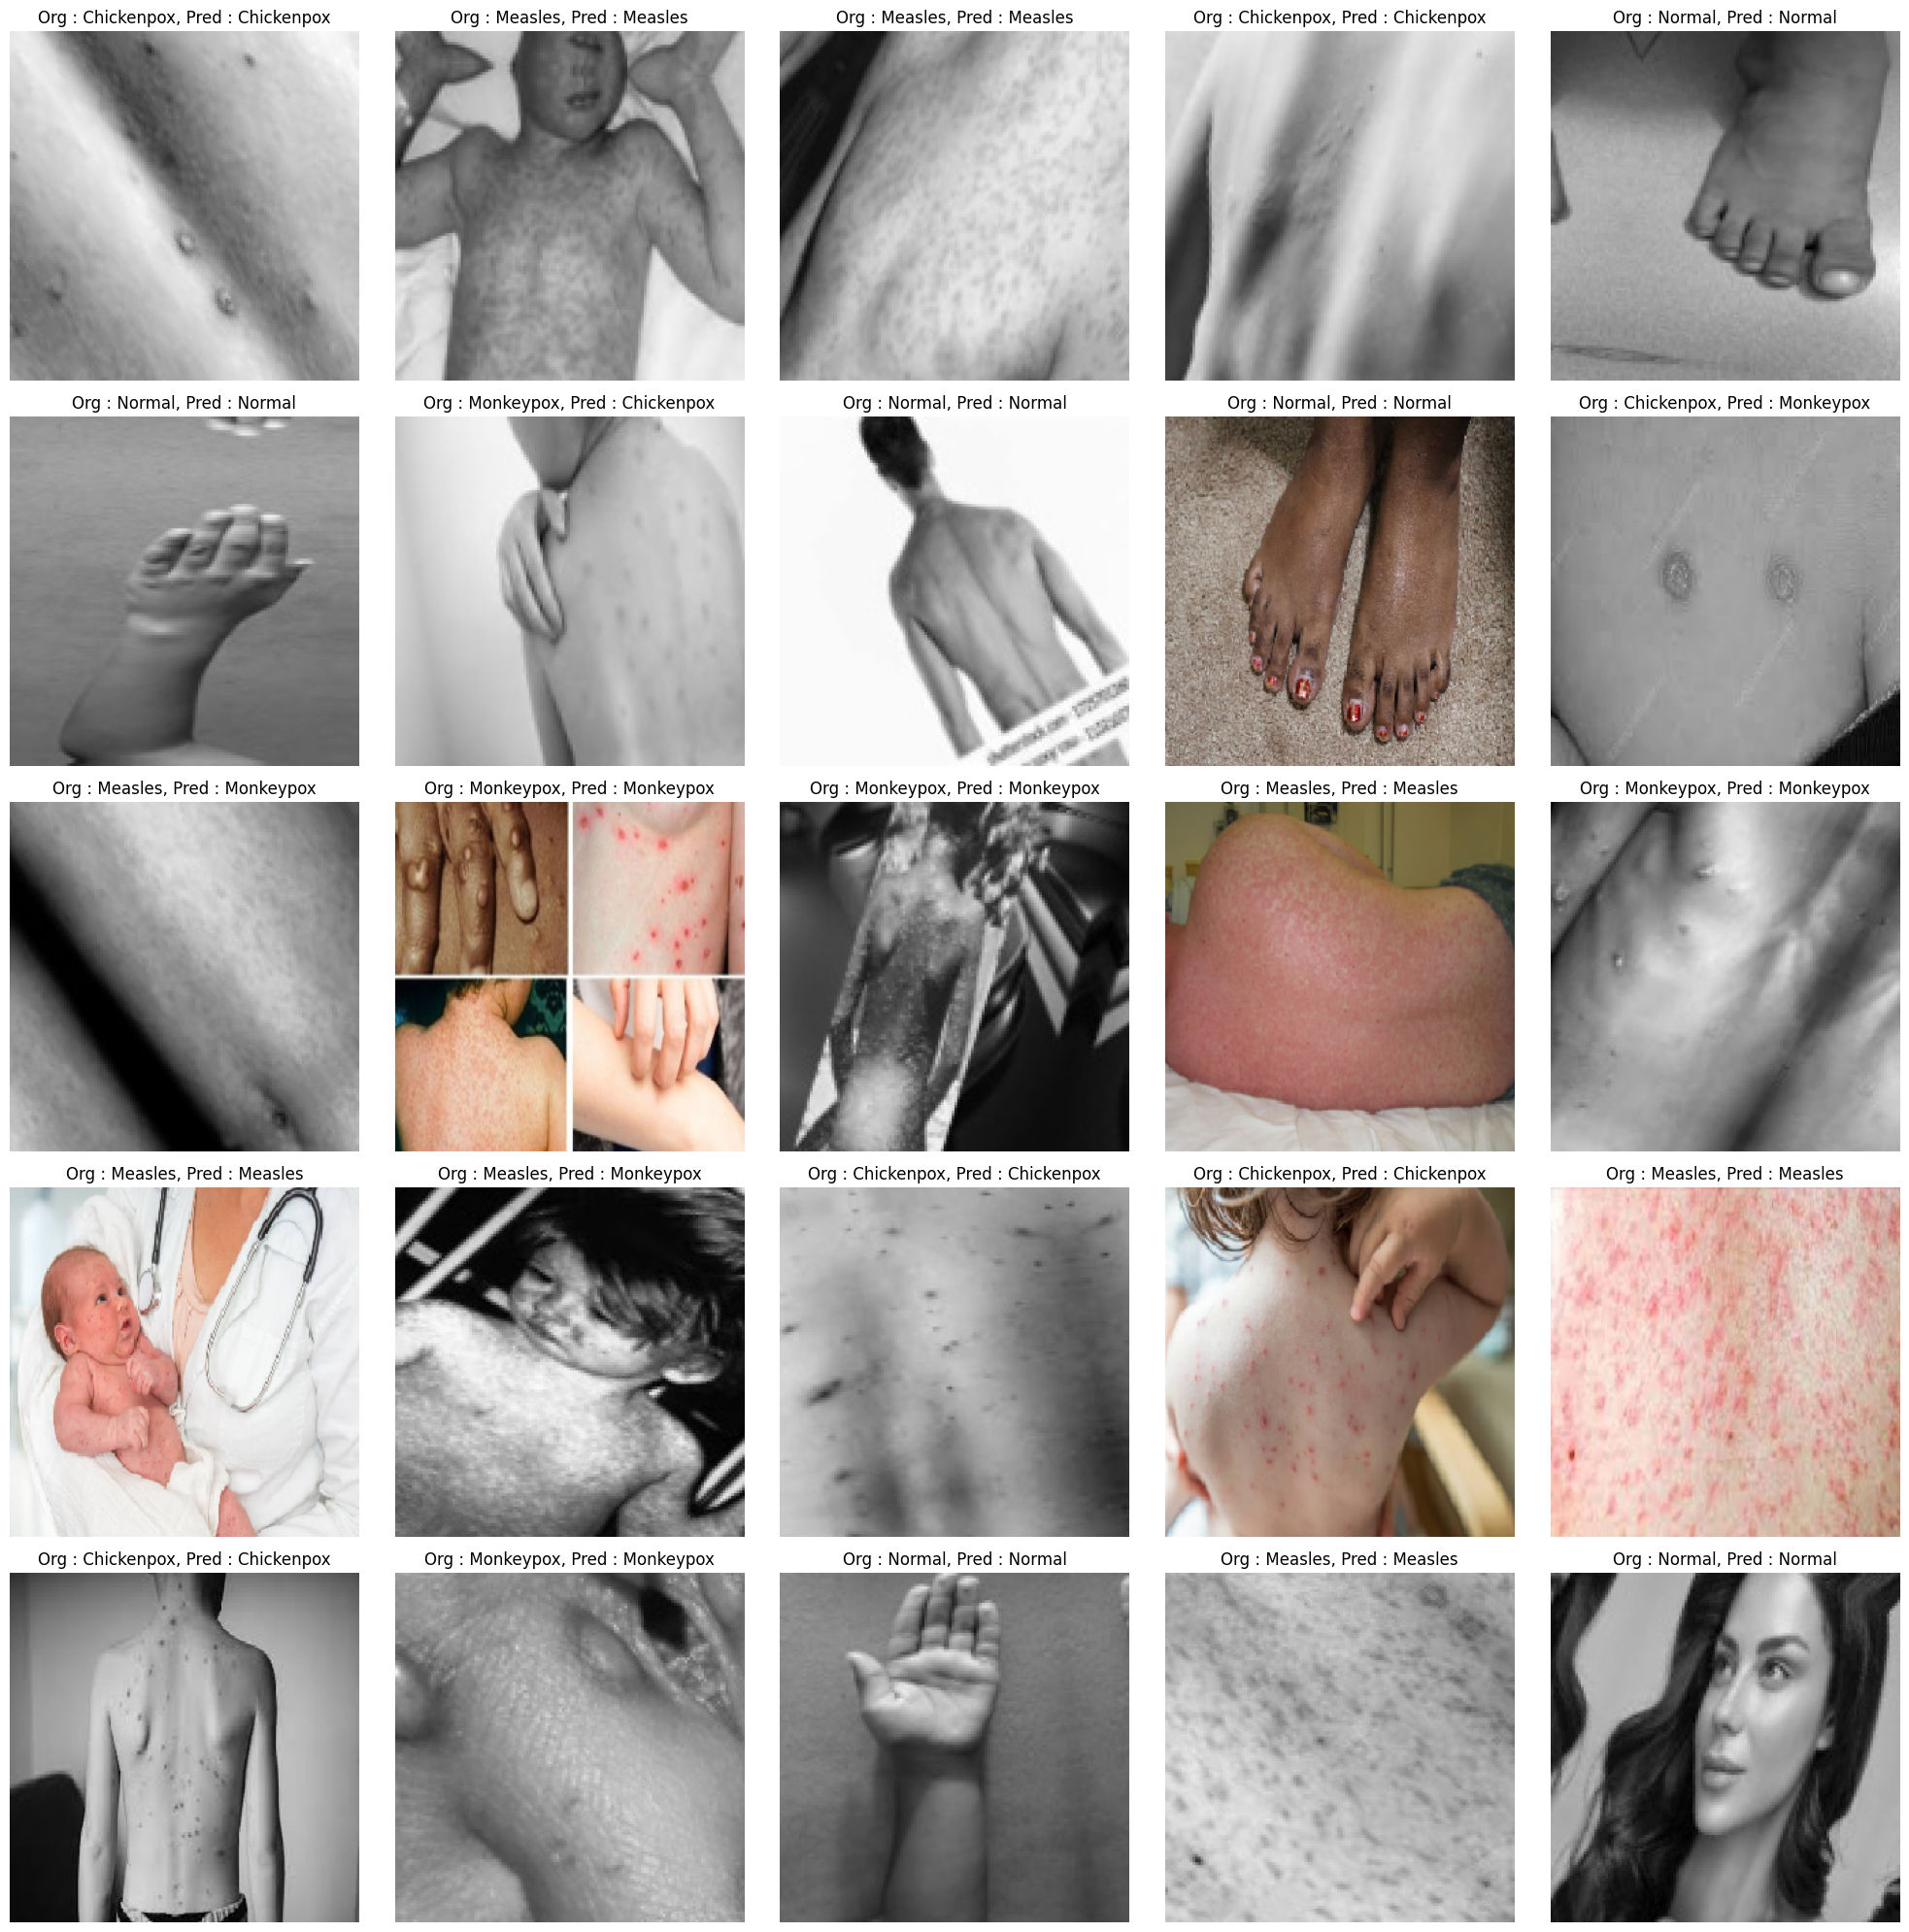

In [ ]:
show_images(model=model, data=test_ds)

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load and preprocess the image you want to check
image_path = '/content/drive/MyDrive/project/data/Monkeypox/download (10).jpg'  # Replace with the actual path to your image
image = load_img(image_path, target_size=(256, 256))
image = img_to_array(image) / 255.0  # Normalize pixel values

# Make predictions on the image
predictions = model.predict(np.expand_dims(image, axis=0))

# Get class names
class_names = train_ds.class_indices.keys()

# Create a list of (class_name, confidence_score) pairs
results = [(class_name, confidence) for class_name, confidence in zip(class_names, predictions[0])]

# Sort results by confidence scores in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Display the sorted results
for class_name, confidence in results:
    print(f"{class_name}: {confidence:.2%}")


1/1 [==============================] - 0s 66ms/step
Monkeypox: 83.74%
Chickenpox: 11.11%
Measles: 2.63%
Normal: 2.53%


1/1 [==============================] - 0s 43ms/step


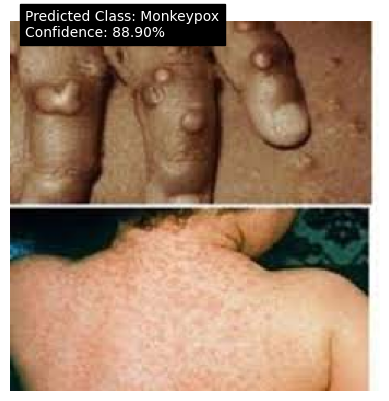

1/1 [==============================] - 0s 35ms/step
Monkeypox: 88.90%
Measles: 10.38%
Chickenpox: 0.59%
Normal: 0.13%


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image you want to check
image_path = '/content/drive/MyDrive/project/data/Monkeypox/download (2).jpg'  # Replace with the actual path to your image
image = load_img(image_path, target_size=(256, 256))
image = img_to_array(image) / 255.0  # Normalize pixel values

# Make predictions on the image
predictions = model.predict(np.expand_dims(image, axis=0))

# Get class names
class_names = train_ds.class_indices.keys()

# Create a list of (class_name, confidence_score) pairs
results = [(class_name, confidence) for class_name, confidence in zip(class_names, predictions[0])]

# Sort results by confidence scores in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the predicted class and confidence score of the top result
predicted_class, confidence_score = results[0]

# Display the image
plt.imshow(image)
plt.axis('off')

# Add annotations for the predicted class and confidence score
annotation = f"Predicted Class: {predicted_class}\nConfidence: {confidence_score:.2%}"
plt.annotate(annotation, (10, 10), color='white', backgroundcolor='black')

# Show the image with annotations
plt.show()
# Make predictions on the image
predictions = model.predict(np.expand_dims(image, axis=0))

# Get class names
class_names = train_ds.class_indices.keys()

# Create a list of (class_name, confidence_score) pairs
results = [(class_name, confidence) for class_name, confidence in zip(class_names, predictions[0])]

# Sort results by confidence scores in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Display the sorted results
for class_name, confidence in results:
    print(f"{class_name}: {confidence:.2%}")
